# Add correlations to the sampled branching ratios

In [1]:
import pandas as pd

In [2]:
import sandy

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

## Retrieve nuclear data file

First, we get the evaluated nuclear data file - in this case U-235 and U-236 from JEFF 3.3 - using get_endf6_file:

In [4]:
endf6 = sandy.get_endf6_file("jeff_33", "decay", [922350, 922360])

Then we can read the decay data information stored in the ENDF6 file and extract the values of the branching ratios and their associated uncertainties:

In [5]:
rdd = sandy.DecayData.from_endf6(endf6)
br = rdd.get_branching_ratio(with_uncertainty=True)
br.data

BR         DBR
ZAM    RTYP RFS                        
922350 4    0   1.00000e+00 1.00000e-04
       6    0   7.20000e-11 2.10000e-11
922360 4    0   1.00000e+00 1.00000e-04
       6    0   9.00000e-10 1.00000e-10

## Create covariance matrix

Assuming the uncertaities equal to the standard deviations, we can build the diagonal covariance matrix with relative standard deviations as follows:

In [6]:
std = br.data.DBR / br.data.BR

In [7]:
cov = sandy.CategoryCov.from_stdev(std)
cov.data

ZAM                  922350                  922360            
RTYP                      4           6           4           6
RFS                       0           0           0           0
ZAM    RTYP RFS                                                
922350 4    0   1.00000e-08 0.00000e+00 0.00000e+00 0.00000e+00
       6    0   0.00000e+00 8.50694e-02 0.00000e+00 0.00000e+00
922360 4    0   0.00000e+00 0.00000e+00 1.00000e-08 0.00000e+00
       6    0   0.00000e+00 0.00000e+00 0.00000e+00 1.23457e-02

## Create perturbation coefficients

In [8]:
nsmp = 500
coeff = cov.sampling(nsmp)

In [9]:
coeff.data

SMP                     0           1           2           3           4    \
ZAM    RTYP RFS                                                               
922350 4    0   9.99980e-01 1.00026e+00 1.00002e+00 1.00007e+00 9.99862e-01   
       6    0   1.50479e+00 1.34945e+00 6.47853e-01 1.25470e+00 1.05195e+00   
922360 4    0   9.99926e-01 1.00008e+00 1.00006e+00 9.99939e-01 9.99971e-01   
       6    0   1.12767e+00 1.01360e+00 8.88150e-01 9.29838e-01 1.02937e+00   

SMP                     5           6           7           8           9    \
ZAM    RTYP RFS                                                               
922350 4    0   1.00027e+00 9.99929e-01 9.99984e-01 9.99939e-01 9.99960e-01   
       6    0   1.13188e+00 9.49243e-01 5.53176e-01 1.71350e+00 1.21122e+00   
922360 4    0   9.99912e-01 1.00002e+00 1.00001e+00 1.00010e+00 1.00007e+00   
       6    0   1.01243e+00 9.52262e-01 8.77491e-01 8.36636e-01 1.01934e+00   

SMP              ...         490         491         492         493  \
ZAM    RTYP RFS  ...                                                   
922350 4    0    ... 1.00017e+00 1.00014e+00 1.00012e+00 1.00002e+00   
       6    0    ... 1.02887e+00 8.38612e-01 9.79369e-01 6.46935e-01   
922360 4    0    ... 1.00009e+00 9.99785e-01 9.99833e-01 1.00010e+00   
       6    0    ... 8.97769e-01 1.11010e+00 8.26259e-01 1.00437e+00   

SMP                     494         495         496         497         498  \
ZAM    RTYP RFS                                                               
922350 4    0   9.99968e-01 1.00005e+00 1.00017e+00 1.00016e+00 1.00006e+00   
       6    0   7.29075e-01 1.36288e+00 1.13016e+00 9.59514e-01 6.30095e-01   
922360 4    0   9.99984e-01 1.00002e+00 9.99994e-01 1.00023e+00 9.99956e-01   
       6    0   1.07078e+00 1.11502e+00 9.22816e-01 9.05187e-01 1.04579e+00   

SMP                     499  
ZAM    RTYP RFS              
922350 4    0   9.99905e-01  
       6    0   1.42055e+00  
922360 4    0   9.99941e-01  
       6    0   8.24146e-01  

[4 rows x 500 columns]

## Apply first perturbation coefficient to branching ratios

This step will be iteratively repeted for each perturbation coefficient to obtain nsmp perturbed branching ratios. The perturbation coefficients are givem as ratio values, e.g., 1.05 for a perturbation of +5%.

In [10]:
perturbation = coeff.data[0].rename("PERT").to_frame()
br_new = br.custom_perturbation(perturbation)

## Normalize branching ratios

The normalization method was implemented to apply the normalization condition to each row of `BranchingRatio.data`, in this way each set of samples wil respect the constraint of the sum of branching ratios equal to one.

In [11]:
br_norm = br_new.normalize()

## Create an ENDF6 file with the perturbed nuclear data

In [12]:
rdd_new = br_norm.to_decaydata(rdd)
endf6_new = rdd_new.to_endf6(endf6).to_file("perturbed_br")

## Comparison of correlation matrices of samples

In [13]:
smp_no_corr = coeff.data.T * br.data.BR.values
frames = []
for i in range(nsmp):
    perturbation = coeff.data[i].rename("PERT").to_frame()
    br_new = br.custom_perturbation(perturbation).normalize()
    frames.append(br_new.data.BR.rename(f"{i}").to_frame().T)
smp_corr = pd.concat(frames)

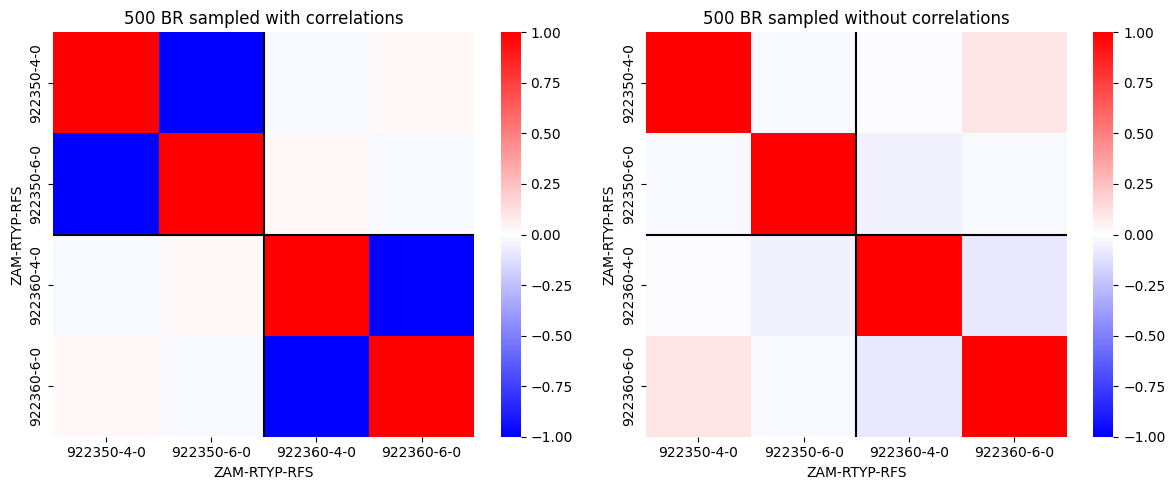

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), dpi=100)
ax1, ax2 = axes

sns.heatmap(smp_corr.corr(), cmap="bwr", vmin=-1, vmax=1, ax=ax1)
ax1.axhline(2, color='k')
ax1.axvline(2, color='k')
ax1.set_title(f'{nsmp} BR sampled with correlations')

sns.heatmap(smp_no_corr.corr(), cmap="bwr", vmin=-1, vmax=1, ax=ax2)
ax2.axhline(2, color='k')
ax2.axvline(2, color='k')
ax2.set_title(f'{nsmp} BR sampled without correlations')

fig.tight_layout()